In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import HeNormal, RandomNormal
import numpy as np

In [3]:
class L2Pool2D(layers.Layer):
    """L2 Pooling layer as used in FaceNet NN2"""
    def __init__(self, pool_size=3, strides=1, padding='same', **kwargs):
        super(L2Pool2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding.upper()
    
    def call(self, inputs):
        # L2 pooling: sqrt(avg(x^2))
        x_squared = tf.square(inputs)
        pooled = tf.nn.avg_pool2d(x_squared, 
                                 ksize=self.pool_size, 
                                 strides=self.strides, 
                                 padding=self.padding)
        return tf.sqrt(pooled + 1e-8)  # Add small epsilon for numerical stability
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'pool_size': self.pool_size,
            'strides': self.strides,
            'padding': self.padding
        })
        return config

class InceptionModule(layers.Layer):
    """Inception module exactly as described in Table 2"""
    def __init__(self, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj, pool_type='max', **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        
        self.n1x1 = n1x1
        self.n3x3_reduce = n3x3_reduce
        self.n3x3 = n3x3
        self.n5x5_reduce = n5x5_reduce
        self.n5x5 = n5x5
        self.pool_proj = pool_proj
        self.pool_type = pool_type
        
        # Branch 1: 1x1 convolution
        if n1x1 > 0:
            self.branch1_conv = layers.Conv2D(n1x1, 1, activation='relu', 
                                            kernel_initializer=HeNormal())
        
        # Branch 2: 1x1 -> 3x3 convolution
        if n3x3_reduce > 0 and n3x3 > 0:
            self.branch2_conv1 = layers.Conv2D(n3x3_reduce, 1, activation='relu',
                                              kernel_initializer=HeNormal())
            self.branch2_conv2 = layers.Conv2D(n3x3, 3, padding='same', activation='relu',
                                              kernel_initializer=HeNormal())
        
        # Branch 3: 1x1 -> 5x5 convolution
        if n5x5_reduce > 0 and n5x5 > 0:
            self.branch3_conv1 = layers.Conv2D(n5x5_reduce, 1, activation='relu',
                                              kernel_initializer=HeNormal())
            self.branch3_conv2 = layers.Conv2D(n5x5, 5, padding='same', activation='relu',
                                              kernel_initializer=HeNormal())
        
        # Branch 4: Pooling -> 1x1 convolution
        if pool_type == 'max':
            self.pool = layers.MaxPooling2D(3, strides=1, padding='same')
        elif pool_type == 'L2':
            self.pool = L2Pool2D(pool_size=3, strides=1, padding='same')
        else:
            self.pool = layers.AveragePooling2D(3, strides=1, padding='same')
        
        if pool_proj > 0:
            self.branch4_conv = layers.Conv2D(pool_proj, 1, activation='relu',
                                            kernel_initializer=HeNormal())
    
    def call(self, inputs):
        outputs = []
        
        # Branch 1: 1x1 conv
        if self.n1x1 > 0:
            branch1_out = self.branch1_conv(inputs)
            outputs.append(branch1_out)
        
        # Branch 2: 1x1 -> 3x3 conv
        if self.n3x3_reduce > 0 and self.n3x3 > 0:
            branch2_out = self.branch2_conv1(inputs)
            branch2_out = self.branch2_conv2(branch2_out)
            outputs.append(branch2_out)
        
        # Branch 3: 1x1 -> 5x5 conv
        if self.n5x5_reduce > 0 and self.n5x5 > 0:
            branch3_out = self.branch3_conv1(inputs)
            branch3_out = self.branch3_conv2(branch3_out)
            outputs.append(branch3_out)
        
        # Branch 4: pool -> 1x1 conv
        if self.pool_proj > 0:
            branch4_out = self.pool(inputs)
            branch4_out = self.branch4_conv(branch4_out)
            outputs.append(branch4_out)
        
        return layers.Concatenate(axis=-1)(outputs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'n1x1': self.n1x1,
            'n3x3_reduce': self.n3x3_reduce,
            'n3x3': self.n3x3,
            'n5x5_reduce': self.n5x5_reduce,
            'n5x5': self.n5x5,
            'pool_proj': self.pool_proj,
            'pool_type': self.pool_type
        })
        return config

class InceptionWithStride(layers.Layer):
    """Inception module with stride for downsampling (3c and 4e)"""
    def __init__(self, n3x3_reduce, n3x3, n5x5_reduce, n5x5, **kwargs):
        super(InceptionWithStride, self).__init__(**kwargs)
        
        self.n3x3_reduce = n3x3_reduce
        self.n3x3 = n3x3
        self.n5x5_reduce = n5x5_reduce
        self.n5x5 = n5x5
        
        # Branch 1: 1x1 -> 3x3 convolution with stride 2
        self.branch1_conv1 = layers.Conv2D(n3x3_reduce, 1, activation='relu',
                                          kernel_initializer=HeNormal())
        self.branch1_conv2 = layers.Conv2D(n3x3, 3, strides=2, padding='same', 
                                          activation='relu', kernel_initializer=HeNormal())
        
        # Branch 2: 1x1 -> 5x5 convolution with stride 2
        self.branch2_conv1 = layers.Conv2D(n5x5_reduce, 1, activation='relu',
                                          kernel_initializer=HeNormal())
        self.branch2_conv2 = layers.Conv2D(n5x5, 5, strides=2, padding='same', 
                                          activation='relu', kernel_initializer=HeNormal())
        
        # Branch 3: Max pooling with stride 2
        self.branch3_pool = layers.MaxPooling2D(3, strides=2, padding='same')
    
    def call(self, inputs):
        # Branch 1: 1x1 -> 3x3 with stride 2
        branch1_out = self.branch1_conv1(inputs)
        branch1_out = self.branch1_conv2(branch1_out)
        
        # Branch 2: 1x1 -> 5x5 with stride 2
        branch2_out = self.branch2_conv1(inputs)
        branch2_out = self.branch2_conv2(branch2_out)
        
        # Branch 3: Max pooling with stride 2
        branch3_out = self.branch3_pool(inputs)
        
        return layers.Concatenate(axis=-1)([branch1_out, branch2_out, branch3_out])
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'n3x3_reduce': self.n3x3_reduce,
            'n3x3': self.n3x3,
            'n5x5_reduce': self.n5x5_reduce,
            'n5x5': self.n5x5
        })
        return config

def create_facenet_nn2(input_shape=(224, 224, 3), embedding_dim=128, num_classes=None, dropout=0.5):
    """
    Create FaceNet NN2 model using Keras Functional API
    
    Args:
        input_shape: Input image shape (default: (224, 224, 3))
        embedding_dim: Dimension of face embeddings (default: 128)
        num_classes: Number of identities for classification (optional)
        dropout: Dropout rate before final FC layer (default: 0.5)
    
    Returns:
        Keras Model
    """
    
    inputs = layers.Input(shape=input_shape, name='input_image')
    
    # Layer 1: Initial convolution (7x7, stride 2)
    x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu',
                     kernel_initializer=HeNormal(), name='conv1')(inputs)
    
    # Layer 2: Max pooling + normalization
    x = layers.MaxPooling2D(3, strides=2, padding='same', name='maxpool1')(x)
    x = tf.nn.local_response_normalization(x, depth_radius=2, bias=1.0, 
                                          alpha=0.0001, beta=0.75, name='norm1')
    
    # Layer 3: Inception (2) - 56x56x64 -> 56x56x192
    x = layers.Conv2D(64, 1, activation='relu', kernel_initializer=HeNormal(),
                     name='inception2_1x1')(x)
    x = layers.Conv2D(192, 3, padding='same', activation='relu', 
                     kernel_initializer=HeNormal(), name='inception2_3x3')(x)
    
    # Layer 4: Normalization + max pooling
    x = tf.nn.local_response_normalization(x, depth_radius=2, bias=1.0,
                                          alpha=0.0001, beta=0.75, name='norm2')
    x = layers.MaxPooling2D(3, strides=2, padding='same', name='maxpool2')(x)
    
    # Layer 5: Inception (3a) - 28x28x192 -> 28x28x256
    x = InceptionModule(n1x1=64, n3x3_reduce=96, n3x3=128,
                       n5x5_reduce=16, n5x5=32, pool_proj=32, 
                       pool_type='max', name='inception3a')(x)
    
    # Layer 6: Inception (3b) - 28x28x256 -> 28x28x320
    x = InceptionModule(n1x1=64, n3x3_reduce=96, n3x3=128,
                       n5x5_reduce=32, n5x5=64, pool_proj=64,
                       pool_type='L2', name='inception3b')(x)
    
    # Layer 7: Inception (3c) - 28x28x320 -> 14x14x640
    x = InceptionWithStride(n3x3_reduce=128, n3x3=256,
                           n5x5_reduce=32, n5x5=64, name='inception3c')(x)
    
    # Layer 8: Inception (4a) - 14x14x640 -> 14x14x640
    x = InceptionModule(n1x1=256, n3x3_reduce=96, n3x3=192,
                       n5x5_reduce=32, n5x5=64, pool_proj=128,
                       pool_type='L2', name='inception4a')(x)
    
    # Layer 9: Inception (4b) - 14x14x640 -> 14x14x640
    x = InceptionModule(n1x1=224, n3x3_reduce=112, n3x3=224,
                       n5x5_reduce=32, n5x5=64, pool_proj=128,
                       pool_type='L2', name='inception4b')(x)
    
    # Layer 10: Inception (4c) - 14x14x640 -> 14x14x640
    x = InceptionModule(n1x1=192, n3x3_reduce=128, n3x3=256,
                       n5x5_reduce=32, n5x5=64, pool_proj=128,
                       pool_type='L2', name='inception4c')(x)
    
    # Layer 11: Inception (4d) - 14x14x640 -> 14x14x640
    x = InceptionModule(n1x1=160, n3x3_reduce=144, n3x3=288,
                       n5x5_reduce=32, n5x5=64, pool_proj=128,
                       pool_type='L2', name='inception4d')(x)
    
    # Layer 12: Inception (4e) - 14x14x640 -> 7x7x1024
    x = InceptionWithStride(n3x3_reduce=160, n3x3=256,
                           n5x5_reduce=64, n5x5=128, name='inception4e')(x)
    
    # Layer 13: Inception (5a) - 7x7x1024 -> 7x7x1024
    x = InceptionModule(n1x1=384, n3x3_reduce=192, n3x3=384,
                       n5x5_reduce=48, n5x5=128, pool_proj=128,
                       pool_type='L2', name='inception5a')(x)
    
    # Layer 14: Inception (5b) - 7x7x1024 -> 7x7x1024
    x = InceptionModule(n1x1=384, n3x3_reduce=192, n3x3=384,
                       n5x5_reduce=48, n5x5=128, pool_proj=128,
                       pool_type='max', name='inception5b')(x)
    
    # Layer 15: Average pooling
    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    
    # Layer 16: Fully connected layer
    if dropout > 0:
        x = layers.Dropout(dropout, name='dropout')(x)
    
    embeddings = layers.Dense(embedding_dim, kernel_initializer=RandomNormal(stddev=0.01),
                             name='embeddings')(x)
    
    # Layer 17: L2 normalization
    embeddings = tf.nn.l2_normalize(embeddings, axis=1, name='l2_normalization')


    # Optional classification layer for training
    if num_classes is not None:
        logits = layers.Dense(num_classes, kernel_initializer=RandomNormal(stddev=0.01),
                             name='logits')(embeddings)
        model = Model(inputs=inputs, outputs=[embeddings, logits], name='FaceNet_NN2')
    else:
        model = Model(inputs=inputs, outputs=embeddings, name='FaceNet_NN2')
    
    return model

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib
from sklearn.model_selection import train_test_split



In [3]:
print(matplotlib.__version__)
print(tf.__version__)

3.9.2
2.10.0


In [4]:
def load_image_paths_by_class(dataset_path):
    
    #สร้าง dictionary 
    class_image_paths = {}

    for class_name in os.listdir(dataset_path): #os.listdir ดึงรายชื่อไฟล์/โฟเดอร์ใน paht
        class_dir = os.path.join(dataset_path, class_name)#os.path.join = images\photo.jpg
        #print(class_dir)
        if os.path.isdir(class_dir):#ตรวจสอบclass_dir เป็นโฟลเดอร์ถ้าเป็นโฟลเดอร์ จะเข้าไปทำงานต่อ
            image_files = [ 
                os.path.join(class_dir, img) #
                for img in os.listdir(class_dir) # ดึงรายชื่อ
                if img.lower().endswith(('.jpg', '.jpeg', '.png')) #
            ]
            if len(image_files) >= 12:  # ขั้นต่ำ 3 ภาพผป
                class_image_paths[class_name] = image_files # สร้าง dictionary

    return class_image_paths


In [5]:
dataset_path = r'C:\InceptionNet\mediamdata' 
dataset_path3 = r"C:\InceptionNet\GLint360K\glint360k_3"
dic = load_image_paths_by_class(dataset_path3)
print(len(dic))
#print(dictm)


14032


In [6]:
classes = list(dic.keys())
#print(classes)
#print(len(classes))

In [7]:
train_classes, val_classes = train_test_split(classes, test_size=0.2, random_state=42)

print(f"จำนวนคลาสสำหรับ Training: {len(train_classes)}")
print(f"จำนวนคลาสสำหรับ Validation: {len(val_classes)}")


จำนวนคลาสสำหรับ Training: 11225
จำนวนคลาสสำหรับ Validation: 2807


In [8]:
train_image_dict1 = {
    class_name: dic[class_name]
    for class_name in train_classes
}

# สร้าง dictionary สำหรับ Validation
val_image_dict1 = {
    class_name: dic[class_name]
    for class_name in val_classes
}
print(f"ขนาดของ Dictionary สำหรับ Training: {len(train_image_dict1)}")
print(f"ขนาดของ Dictionary สำหรับ Validation: {len(val_image_dict1)}")



ขนาดของ Dictionary สำหรับ Training: 11225
ขนาดของ Dictionary สำหรับ Validation: 2807


In [9]:
# ปริ้นชื่อคลาสสำหรับ Training
#print("\n--- รายชื่อคลาสสำหรับ Training ---")
#for class_name in train_classes:
    #print(class_name)

# ---
# ปริ้นชื่อคลาสสำหรับ Validation
print("\n--- รายชื่อคลาสสำหรับ Validation ---")
for class_name in val_classes:
    print(class_name)


--- รายชื่อคลาสสำหรับ Validation ---
264427
325435
170797
107026
192910
267447
275211
291875
2299
38893
254775
257934
298845
190328
68713
38295
283094
176427
6511
233570
269177
162807
171064
20137
302913
165467
174469
222770
358956
149532
104860
18399
346805
43783
192658
315225
259712
41120
52053
206048
312885
209426
144345
326979
304320
264490
64413
88187
253434
36735
139025
240142
275942
113325
156648
232220
121324
173586
141331
156270
222925
236203
308003
74526
60177
88447
334234
283994
317656
179217
38350
166236
317606
291314
305888
313289
216339
252153
278997
193538
311686
158496
67789
259305
37273
167243
232522
122471
240077
168774
211264
143428
180315
227541
259134
208533
333068
129305
275125
333903
78360
195166
33602
198954
1244
221761
232257
328833
107650
151845
112970
51363
295792
233066
331256
176331
46401
290345
214706
177052
88773
301279
271749
117671
88073
304655
37119
10849
126113
77863
191435
211060
96432
128853
115722
14713
358533
143789
103654
46351
137868
140211
329

In [ ]:
def loadimage(image_path):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.cast(img, tf.float32)
        img = img / 255.0  # Normalization
        img = tf.clip_by_value(img, 0.0, 1.0)#img = tf.where(tf.math.is_finite(img), img, tf.zeros_like(img)) # แทนที่ค่า NaN หรือ Inf ด้วย 0
        img.set_shape((224, 224, 3))
        return img
    except:
        print(f"Error loading image {image_path}. Returning a zero tensor.")
        return tf.zeros((224, 224, 3), dtype=tf.float32)
    
    

##Online Triplet Mining

In [11]:
import random
def triplet_generator(image_dict, num_triplets_per_epoch):
    # image_dict คือ dictionary ของคุณที่ได้จากขั้นตอนที่ 1
    # num_triplets_per_epoch คือจำนวน triplet ที่ต้องการใน 1 รอบ (epoch)
    classes = list(image_dict.keys()) # ดึงชื่อคลาสทั้งหมด
    for _ in range(num_triplets_per_epoch):
        # 1. สุ่ม anchor และ positive จากคลาสเดียวกัน
        anchor_class = random.choice(classes)
        # ตรวจสอบว่าคลาสนั้นมีรูปภาพอย่างน้อย 2 รูป
        if len(image_dict[anchor_class]) < 2:
            continue

        a, p = random.sample(image_dict[anchor_class], 2)
        
        # 2. สุ่ม negative จากคลาสอื่น
        neg_classes = [c for c in classes if c != anchor_class]
        if not neg_classes:
            continue
            
        negative_class = random.choice(neg_classes)
        n = random.choice(image_dict[negative_class])
        
        # คืนค่า (yield) Path ของรูปภาพ
        yield (a, p, n)
        

In [12]:
def builddataset1(image_dict, num_triplets, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: triplet_generator(image_dict, num_triplets),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    )
    dataset = dataset.map(
        lambda a, p, n: (loadimage(a), loadimage(p), loadimage(n)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) #เพิ่มมิติ btach
    return dataset

triple = 65000
BATCH_SIZE = 4

train_dataset = builddataset1(train_image_dict1, triple, BATCH_SIZE)
val_dataset = builddataset1(val_image_dict1, int(triple*0.1), BATCH_SIZE)

In [13]:
l = 0
# ทดสอบ
for a, p, n in train_dataset.take(5):
    print("Anchor batch shape:", a.shape)
    print("Positive batch shape:", p.shape)
    print("Negative batch shape:", n.shape)
    print("ลูปที่:", a)
    #l = l + 1Q
    print("ลูปที่:", l)

Anchor batch shape: (4, 224, 224, 3)
Positive batch shape: (4, 224, 224, 3)
Negative batch shape: (4, 224, 224, 3)
ลูปที่: tf.Tensor(
[[[[1.09803922e-01 1.33333340e-01 7.84313753e-02]
   [1.09803922e-01 1.33333340e-01 7.84313753e-02]
   [1.09803922e-01 1.33333340e-01 7.84313753e-02]
   ...
   [5.86274505e-01 5.10784328e-01 4.11764711e-01]
   [5.74509799e-01 5.04901946e-01 4.03921574e-01]
   [5.68627477e-01 5.01960814e-01 4.00000006e-01]]

  [[1.14705883e-01 1.38235301e-01 8.33333358e-02]
   [1.14460781e-01 1.37990192e-01 8.35784301e-02]
   [1.13970585e-01 1.37500003e-01 8.40686262e-02]
   ...
   [5.91421545e-01 5.15931368e-01 4.16911751e-01]
   [5.80147088e-01 5.10539234e-01 4.09558833e-01]
   [5.74509799e-01 5.07843137e-01 4.05882359e-01]]

  [[1.24509804e-01 1.48039222e-01 9.31372568e-02]
   [1.23774506e-01 1.47303924e-01 9.38725471e-02]
   [1.22303918e-01 1.45833328e-01 9.53431353e-02]
   ...
   [6.01715684e-01 5.26225507e-01 4.27205890e-01]
   [5.91421545e-01 5.21813750e-01 4.20833

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Lambda, Input,Dropout

def QQQ():
    input_shape = (224, 224, 3)

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    # เพิ่มโค้ดนี้ในฟังก์ชัน cor() ก่อน return model
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128)(x)
    embedding = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    
    # สร้างโมเดลและ return
    model = Model(inputs=base_model.input, outputs=embedding)
    
    return model

In [25]:
def create_resnet_facenet(input_shape=(160, 160, 3), embedding_dim=128):

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = Dropout(0.5)(x)
    x = Dense(embedding_dim)(x)
    embedding = Lambda(lambda y: tf.math.l2_normalize(y, axis=1), name='l2_normalization')(x)

    # สร้าง Model
    model = Model(inputs=inputs, outputs=embedding)
    return model

In [26]:
model = QQQ()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [28]:
def triplet_loss(anchor, positive, negative, alpha=0.2):
    epsilon = 1e-8
    
    # คำนวณระยะห่างแบบ Euclidean squared
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    
    # เพิ่ม epsilon และใช้ tf.clip_by_value เพื่อป้องกันค่าผิดปกติ
    pos_dist = tf.clip_by_value(pos_dist, epsilon, 10.0)
    neg_dist = tf.clip_by_value(neg_dist, epsilon, 10.0)
    
    # คำนวณ basic loss
    basic_loss = pos_dist - neg_dist + alpha
    
    # ใช้ tf.nn.relu แทน tf.maximum
    loss = tf.reduce_mean(tf.nn.relu(basic_loss))
    
    # ตรวจสอบ NaN
    loss = tf.where(tf.math.is_finite(loss), loss, tf.constant(0.0))
    
    return loss


In [29]:
import tensorflow as tf

def losshard_mining(anchor, positive, negative, alpha=0.2):
    """
    Computes Triplet Loss with Hard Triplet Mining.
    """
    # 1. Calculate squared Euclidean distances
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

    # 2. Find all valid triplets in the batch
    all_triplets = pos_dist - neg_dist + alpha
    
    # 3. Filter out the easy triplets (loss <= 0)
    hard_triplets = tf.where(all_triplets > 0, all_triplets, tf.zeros_like(all_triplets))

    # 4. Take the mean of the hard triplets
    # Add a small value to the denominator to avoid division by zero
    num_hard_triplets = tf.reduce_sum(tf.cast(hard_triplets > 0, dtype=tf.float32))
    
    # Check if there are any hard triplets. If not, the loss is 0
    if num_hard_triplets > 0:
        loss = tf.reduce_sum(hard_triplets) / num_hard_triplets
    else:
        loss = tf.constant(0.0)

    # Return the loss
    return loss

In [ ]:
@tf.function
def triplet_loss_val(anchor, positive, negative, alpha=0.2):
    epsilon = 1e-8
    
    # คำนวณระยะห่างแบบ Euclidean squared
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    
    # เพิ่ม epsilon และใช้ tf.clip_by_value เพื่อป้องกันค่าผิดปกติ
    pos_dist = tf.clip_by_value(pos_dist, epsilon, 10.0)
    neg_dist = tf.clip_by_value(neg_dist, epsilon, 10.0)
    
    # คำนวณ basic loss
    basic_loss = pos_dist - neg_dist + alpha
    
    # ใช้ tf.nn.relu แทน tf.maximum
    loss = tf.reduce_mean(tf.nn.relu(basic_loss))
    
    # ตรวจสอบ NaN
    loss = tf.where(tf.math.is_finite(loss), loss, tf.constant(0.0))
    
    return loss

In [30]:
@tf.function
def train_step(anchor, positive, negative):
    with tf.GradientTape() as tape:
        anchor_embedding = model(anchor, training=True)
        positive_embedding = model(positive, training=True)
        negative_embedding = model(negative, training=True)
        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

--- เริ่มการฝึกโมเดล ---

--- Epoch 1/50 ---
Batch 5000, Training Loss: 0.2273
Batch 10000, Training Loss: 0.1292
Batch 15000, Training Loss: 0.1406

สรุป Epoch 1/50, Training Loss เฉลี่ย: 0.1810

--- เริ่ม Validation ---
Validation Batch 500, Validation Loss: 0.2207
Validation Batch 1000, Validation Loss: 0.1797
Validation Batch 1500, Validation Loss: 0.2212
สรุป Validation Loss เฉลี่ย: 0.1809

--- Epoch 2/50 ---
Batch 5000, Training Loss: 0.1683
Batch 10000, Training Loss: 0.1406
Batch 15000, Training Loss: 0.1708

สรุป Epoch 2/50, Training Loss เฉลี่ย: 0.1581

--- เริ่ม Validation ---
Validation Batch 500, Validation Loss: 0.1924
Validation Batch 1000, Validation Loss: 0.1721
Validation Batch 1500, Validation Loss: 0.1740
สรุป Validation Loss เฉลี่ย: 0.1554

--- Epoch 3/50 ---
Batch 5000, Training Loss: 0.1243
Batch 10000, Training Loss: 0.1905
Batch 15000, Training Loss: 0.0385

สรุป Epoch 3/50, Training Loss เฉลี่ย: 0.1470

--- เริ่ม Validation ---
Validation Batch 500, Validation

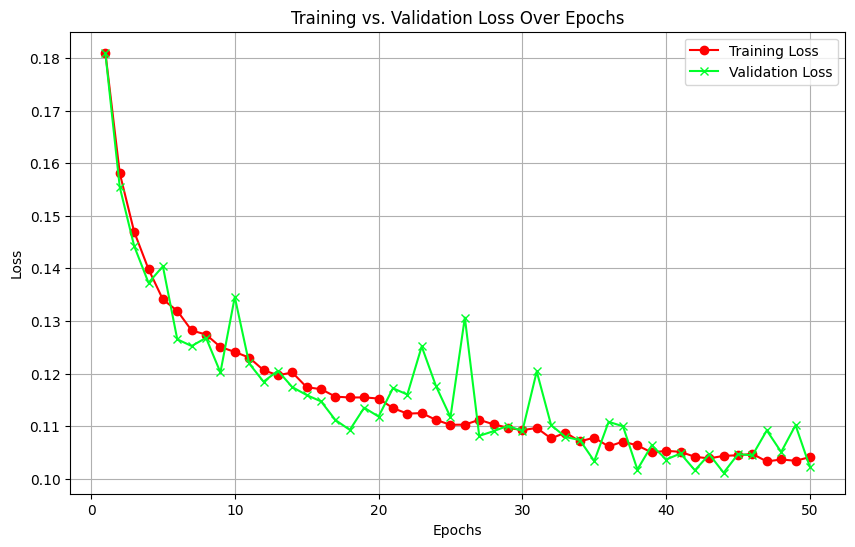


--- การฝึกโมเดลเสร็จสิ้น ---


In [31]:
EPOCHS = 50
print("--- เริ่มการฝึกโมเดล ---")
train_loss_history = []
val_loss_history = []
for epoch in range(EPOCHS):
    total_loss = 0.0
    num_batches = 0
    
    # วนลูปใน training dataset
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    for anchor, positive, negative in train_dataset:
        loss = train_step(anchor, positive, negative)
        total_loss += loss
        num_batches += 1
        
        # ปริ้นท์
        if num_batches % 5000 == 0:
            print(f"Batch {num_batches}, Training Loss: {loss.numpy():.4f}")
    
    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    print(f"\nสรุป Epoch {epoch+1}/{EPOCHS}, Training Loss เฉลี่ย: {avg_loss.numpy():.4f}")
    train_loss_history.append(avg_loss)
    # Optional: ตรวจสอบ Validation Loss ในแต่ละ Epoch
    val_total_loss = 0.0
    val_num_batches = 0
    
    # วนลูปใน validation dataset
    print("\n--- เริ่ม Validation ---")
    for anchor, positive, negative in val_dataset:
        anchor_embedding = model(anchor, training=False)
        positive_embedding = model(positive, training=False)
        negative_embedding = model(negative, training=False)
        val_loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        val_total_loss += val_loss
        val_num_batches += 1
        
        # ปริ้นท์ Val
        if val_num_batches % 500 == 0:
             print(f"Validation Batch {val_num_batches}, Validation Loss: {val_loss.numpy():.4f}")
             
    val_avg_loss = val_total_loss / val_num_batches if val_num_batches > 0 else 0
    print(f"สรุป Validation Loss เฉลี่ย: {val_avg_loss.numpy():.4f}")
    val_loss_history.append(val_avg_loss)
    nameModel = f"modelR{epoch+1}.h5"
    model.save(nameModel)

plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_loss_history, 'o-', label='Training Loss',color='red')
plt.plot(range(1, EPOCHS + 1), val_loss_history, 'x-', label='Validation Loss',color="#00FF2A")
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- การฝึกโมเดลเสร็จสิ้น ---")
model.save("2M.h5")


In [ ]:
import tensorflow as tf

def hard_mining(anchor, positive, negative, alpha=0.2):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    hardest_pos_dist = tf.reduce_max(pos_dist)
    hardest_neg_dist = tf.reduce_min(neg_dist)
    basic_loss = hardest_pos_dist - hardest_neg_dist + alpha
    loss = tf.nn.relu(basic_loss)
    return loss

recall
f1score
precision
auc
accuracy

ROC Curve กราฟ